# Comparison between the OpticStudio and Optiland backends

In [1]:
from __future__ import annotations

from dataclasses import asdict
from typing import TYPE_CHECKING, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import CenteredNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import center_of_mass

import visisipy
from visisipy.backend import BackendSettings
from visisipy.opticstudio import OpticStudioBackend
from visisipy.optiland import OptilandBackend

if TYPE_CHECKING:
    from visisipy.analysis.cardinal_points import CardinalPointsResult
    from visisipy.analysis.refraction import FourierPowerVectorRefraction

In [2]:
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning, module="zospy")

Initialize both backends

In [3]:
BACKEND_SETTINGS = BackendSettings(
    field_type="angle",
    fields=[(0, 0)],
    wavelengths=[0.543],
    aperture_type="float_by_stop_size",
    aperture_value=3.0,
)

OpticStudioBackend.initialize(**BACKEND_SETTINGS, mode="standalone", ray_aiming="off")
OptilandBackend.initialize(**BACKEND_SETTINGS)

Define an eye model. Instead of the default material model (which is a fitted model for all wavelengths), we will use the refractive indices of the Navarro model for light of 543 nm.

In [4]:
model = visisipy.EyeModel(geometry=visisipy.models.NavarroGeometry(), materials=visisipy.models.NavarroMaterials543())
model_myopic = visisipy.EyeModel(
    visisipy.models.create_geometry(axial_length=model.geometry.axial_length + 2), visisipy.models.NavarroMaterials543()
)
model_hyperopic = visisipy.EyeModel(
    visisipy.models.create_geometry(axial_length=model.geometry.axial_length - 2), visisipy.models.NavarroMaterials543()
)

## Cardinal points analysis

Calculate the cardinal point locations and the difference between the two backends.

In [5]:
def cardinal_points_to_dataframe(cardinal_points: CardinalPointsResult):
    """
    Convert cardinal points to a pandas DataFrame.
    """
    cardinal_points_dict = {
        k: (float("nan"), float("nan")) if v is NotImplemented else v for k, v in asdict(cardinal_points).items()
    }

    return pd.DataFrame.from_dict(cardinal_points_dict, orient="index", columns=["object", "image"])

In [6]:
opticstudio_cardinal_points = visisipy.analysis.cardinal_points(model=model, backend=OpticStudioBackend)
optiland_cardinal_points = visisipy.analysis.cardinal_points(model=model, backend=OptilandBackend)

cardinal_points_comparison = cardinal_points_to_dataframe(opticstudio_cardinal_points).join(
    cardinal_points_to_dataframe(optiland_cardinal_points), lsuffix="_opticstudio", rsuffix="_optiland"
)

cardinal_points_comparison["object_difference"] = (
    cardinal_points_comparison["object_optiland"] - cardinal_points_comparison["object_opticstudio"]
)
cardinal_points_comparison["image_difference"] = (
    cardinal_points_comparison["image_optiland"] - cardinal_points_comparison["image_opticstudio"]
)

cardinal_points_comparison

,object_opticstudio,image_opticstudio,object_optiland,image_optiland,object_difference,image_difference
focal_lengths,-16.467904,22.029115,-16.467904,22.029115,-1.320532e-07,3.574475e-07
focal_points,-14.885414,0.000014,-14.885414,0.000014,-4.542796e-07,-2.605261e-07
principal_points,1.582490,-22.029102,1.582490,-22.029102,-3.222264e-07,3.820264e-07
anti_principal_points,-31.353319,22.029129,-31.353319,22.029129,4.136672e-07,9.692146e-08
nodal_points,7.143701,-16.467890,7.143701,-16.467890,-9.683209e-08,-3.925792e-07
anti_nodal_points,-36.914530,16.467918,-36.914530,16.467918,1.882729e-07,-1.284729e-07


## FFT PSF analysis

Calculate FFT PSFs for both backends and compare the results.
The difference plots show the relative difference, but PSF values smaller than 0.001 are not shown to avoid zero division errors.

In [7]:
def plot_dataframe(
    ax: plt.Axes,
    df: pd.DataFrame,
    title: str,
    cbar_label: str = "Relative intensity",
    xlabel: str = "X [μm]",
    ylabel: str = "Y [μm]",
    **kwargs,
):
    im = ax.imshow(
        df.values,
        extent=(df.columns[0], df.columns[-1], df.index[0], df.index[-1]),
        origin="lower",
        **kwargs,
    )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.colorbar(im, label=cbar_label, cax=cax)


def _align_and_compare_psfs(
    psf1: pd.DataFrame, psf2: pd.DataFrame, shift_max_distance: int = 10, center_of_mass_threshold: float = 0.001
) -> pd.DataFrame:
    """Shifts the PSFs to correct for alignment differences and returns their difference."""

    center_psf1 = np.array(center_of_mass(psf1.values > center_of_mass_threshold))
    center_psf2 = np.array(center_of_mass(psf2.values > center_of_mass_threshold))

    center_difference = np.round(center_psf2 - center_psf1).astype(int)

    if abs(center_difference[0]) < shift_max_distance and abs(center_difference[1]) < shift_max_distance:
        # Align the peaks of the two PSFs
        psf1_shifted = np.roll(
            psf1.values,
            center_difference,
            axis=(0, 1),
        )
    else:
        # If peaks are not close, use a default value based on sampling differences
        psf1_shifted = np.roll(
            psf1.values,
            (0, 1),
            axis=(0, 1),
        )

    return pd.DataFrame(
        psf1_shifted - psf2.values,
        index=psf1.index,
        columns=psf1.columns,
    )


def compare_fft_psfs(
    model: visisipy.EyeModel,
    field: tuple[float, float],
    sampling: int = 128,
):
    """
    Compare FFT PSFs for OpticStudio and Optiland backends.
    """
    shift_max_peak_distance = 10  # Maximum distance to shift the PSF peak for alignment

    fft_psf_opticstudio = visisipy.analysis.fft_psf(
        model=model,
        sampling=sampling,
        field_coordinate=field,
        backend=OpticStudioBackend,
    )

    fft_psf_optiland = visisipy.analysis.fft_psf(
        model=model,
        sampling=sampling,
        field_coordinate=field,
        backend=OptilandBackend,
    )

    fig, ax = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
    plot_dataframe(ax[0], fft_psf_opticstudio, "OpticStudio FFT PSF")
    plot_dataframe(ax[1], fft_psf_optiland, "Optiland FFT PSF")

    comparison = _align_and_compare_psfs(
        fft_psf_opticstudio, fft_psf_optiland, shift_max_distance=shift_max_peak_distance
    )
    plot_dataframe(ax[2], comparison, "Difference", "OpticStudio - Optiland", cmap="coolwarm", norm=CenteredNorm())

    fig.suptitle(f"FFT PSF Comparison for x={field[0]}°, y={field[1]}°")

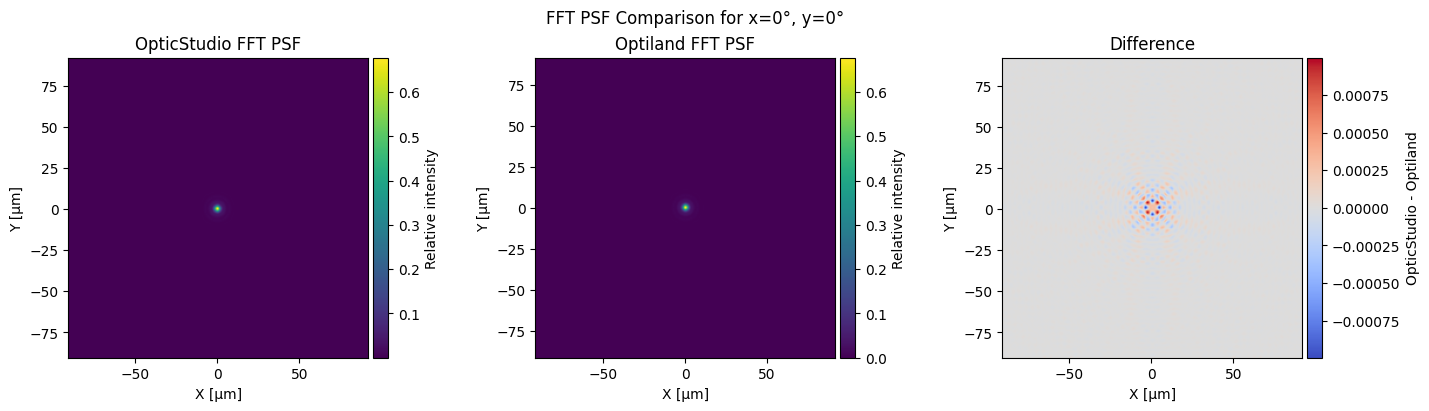

In [8]:
compare_fft_psfs(model, field=(0, 0))

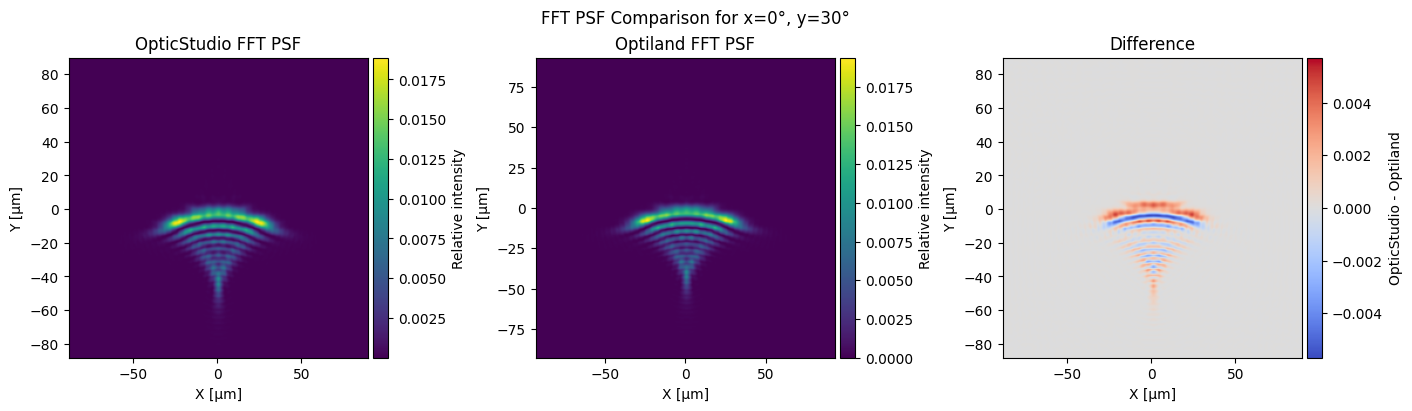

In [9]:
compare_fft_psfs(model, field=(0, 30))

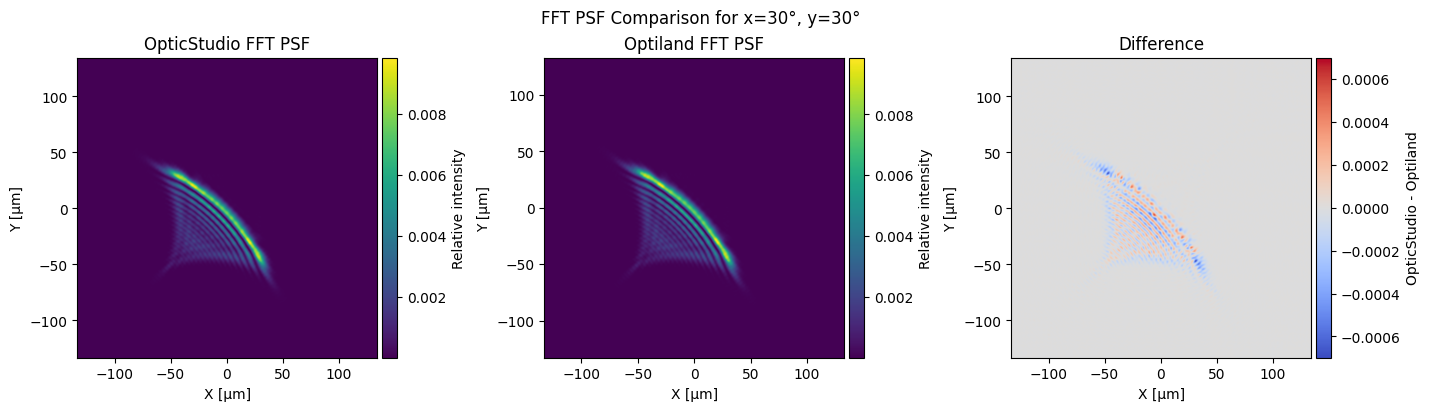

In [10]:
compare_fft_psfs(model, field=(30, 30), sampling=256)

## Huygens PSF analysis

Calculate Huygens PSFs for both backends and plot them side by side.
Because both backends use different sampling strategies and PSF extents, the PSFs are not directly comparable, but they should be qualitatively similar.

In [11]:
def compare_huygens_psfs(
    model: visisipy.EyeModel, field: tuple[float, float], pupil_sampling: int = 128, image_sampling: int = 128
):
    """
    Compare Huygens PSFs for OpticStudio and Optiland backends.
    """
    huygens_psf_opticstudio = visisipy.analysis.huygens_psf(
        model=model,
        field_coordinate=field,
        pupil_sampling=pupil_sampling,
        image_sampling=image_sampling,
        backend=OpticStudioBackend,
    )

    huygens_psf_optiland = visisipy.analysis.huygens_psf(
        model=model,
        field_coordinate=field,
        pupil_sampling=pupil_sampling,
        image_sampling=image_sampling,
        backend=OptilandBackend,
    )

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    plot_dataframe(ax[0], huygens_psf_opticstudio, "OpticStudio Huygens PSF")
    plot_dataframe(ax[1], huygens_psf_optiland, "Optiland Huygens PSF")

    fig.suptitle(f"Huygens PSF Comparison for x={field[0]}°, y={field[1]}°")

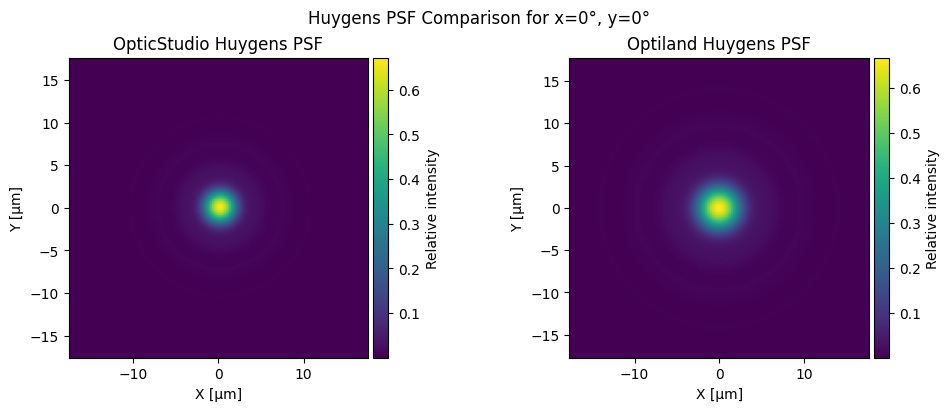

In [12]:
compare_huygens_psfs(model, field=(0, 0))

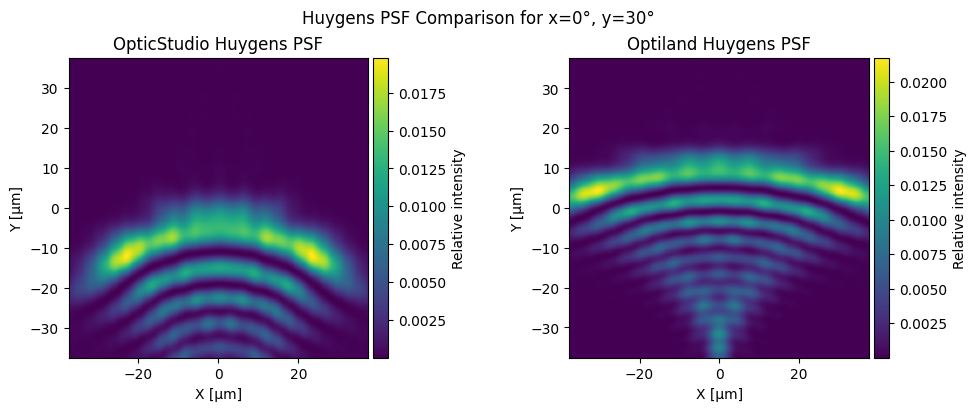

In [13]:
compare_huygens_psfs(model, field=(0, 30), pupil_sampling=128, image_sampling=256)

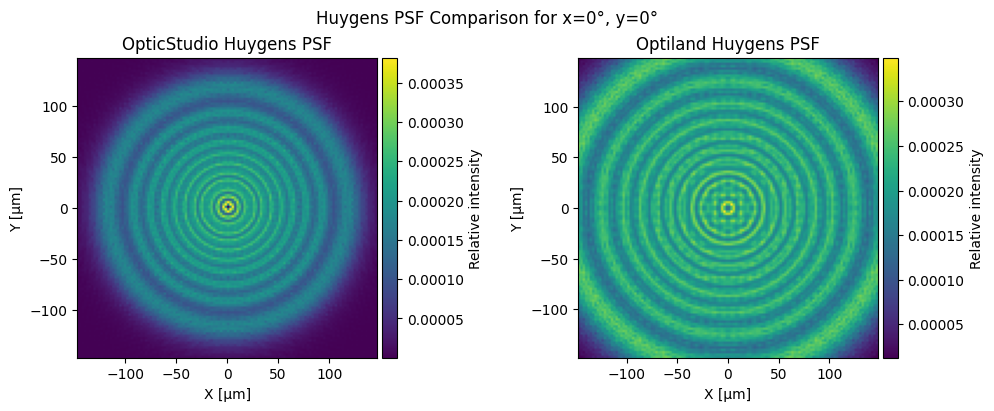

In [14]:
compare_huygens_psfs(model_myopic, field=(0, 0))

## OPD map

Calculate Optical Path Difference (OPD) maps for both backends and compare the results.

In [15]:
def compare_opd_maps(model: visisipy.EyeModel, field: tuple[float, float], sampling: int = 128):
    """
    Compare OPD maps for OpticStudio and Optiland backends.
    """
    opd_map_opticstudio = visisipy.analysis.opd_map(
        model=model,
        field_coordinate=field,
        sampling=sampling,
        remove_tilt=False,
        use_exit_pupil_shape=False,
        backend=OpticStudioBackend,
    )

    opd_map_optiland = visisipy.analysis.opd_map(
        model=model,
        field_coordinate=field,
        sampling=sampling - 1,
        remove_tilt=False,
        use_exit_pupil_shape=False,
        backend=OptilandBackend,
    )

    difference = pd.DataFrame(
        opd_map_opticstudio.values[1:, 1:] - opd_map_optiland.values,
        index=opd_map_optiland.index,
        columns=opd_map_optiland.columns,
    )

    fig, ax = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
    plot_dataframe(
        ax[0], opd_map_opticstudio, "OpticStudio OPD map", cbar_label="OPD [Waves]", xlabel="Px", ylabel="Py"
    )
    plot_dataframe(ax[1], opd_map_optiland, "Optiland OPD map", cbar_label="OPD [Waves]", xlabel="Px", ylabel="Py")
    plot_dataframe(
        ax[2],
        difference,
        "Difference",
        "OpticStudio - Optiland",
        cmap="coolwarm",
        norm=CenteredNorm(),
        xlabel="Px",
        ylabel="Py",
    )

    fig.suptitle(f"OPD map Comparison for x={field[0]}°, y={field[1]}°")

    return opd_map_opticstudio, opd_map_optiland, difference

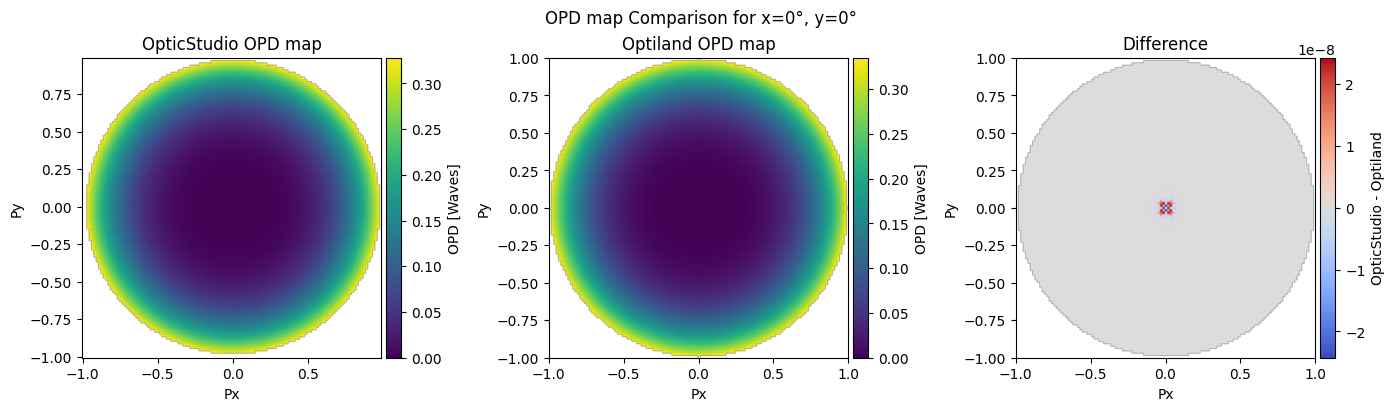

In [16]:
_ = compare_opd_maps(model, field=(0, 0))

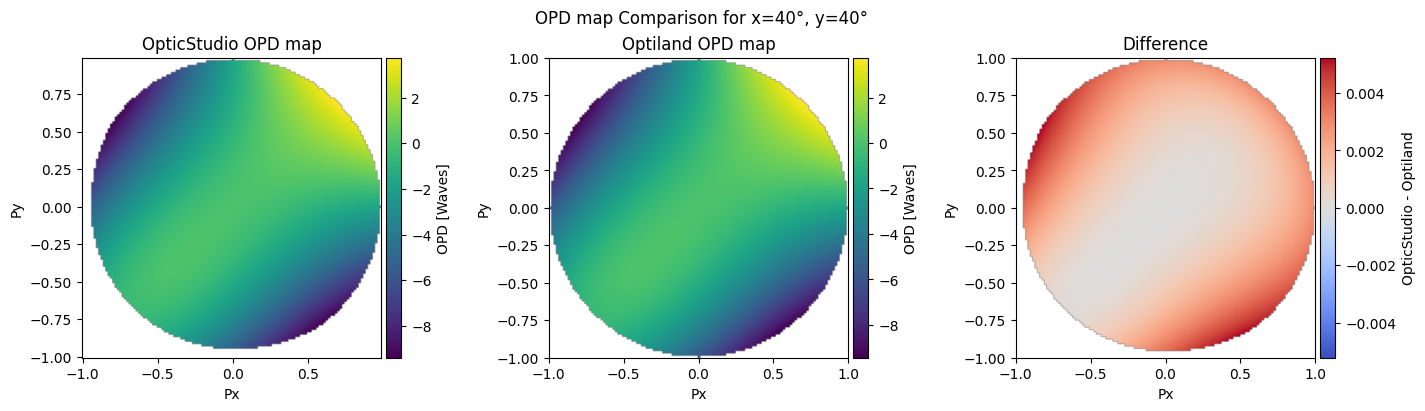

In [17]:
_ = compare_opd_maps(model, field=(40, 40))

Unfortunately, the OPD maps at off-axis fields cannot be compared directly, because OpticStudio takes the exit pupil shape into account even if this is disabled.

## Raytracing analysis

Perform a number of ray traces in both backends and plot the results on top of each other.

In [18]:
RAYTRACE_FIELDS = [(0, y) for y in np.arange(0, 90, step=5).astype(float)]

raytrace_opticstudio = visisipy.analysis.raytrace(
    model=model,
    coordinates=RAYTRACE_FIELDS,
    wavelengths=[0.543],
    field_type="angle",
    pupil=(0, 0),
    backend=OpticStudioBackend,
)

raytrace_optiland = visisipy.analysis.raytrace(
    model=model,
    coordinates=RAYTRACE_FIELDS,
    wavelengths=[0.543],
    field_type="angle",
    pupil=(0, 0),
    backend=OptilandBackend,
)

# Optiland uses different coordinate conventions
raytrace_optiland["z"] -= model.geometry.cornea_thickness + model.geometry.anterior_chamber_depth

Plot the ray trace results on top of each other.

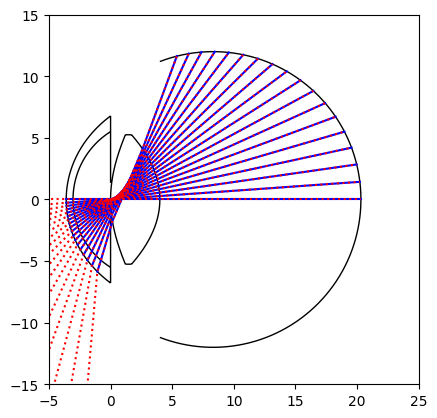

In [19]:
def plot_raytrace_result(raytrace_result: pd.DataFrame, ax: plt.Axes, color="blue", linestyle="-"):
    for _, df in raytrace_result.groupby("field"):
        ax.plot(df.z, df.y, color=color, linestyle=linestyle)


fig, ax = plt.subplots()

visisipy.plots.plot_eye(ax=ax, geometry=model.geometry, lens_edge_thickness=0.5)

plot_raytrace_result(raytrace_opticstudio, ax=ax)
plot_raytrace_result(raytrace_optiland, ax=ax, color="red", linestyle=":")

ax.set_xlim(-5, 25)
ax.set_ylim(-15, 15)
ax.set_aspect("equal")

Calculate the distances between the ray trace results point by point and plot them as a function of the Z-coordinate and the surface index.

In [20]:
_select_columns = ["field", "index", "x", "y", "z"]

raytrace_comparison = pd.merge(
    raytrace_opticstudio[_select_columns],
    raytrace_optiland[_select_columns],
    on=["field", "index"],
    suffixes=("_opticstudio", "_optiland"),
).query("index != 0")

raytrace_comparison.eval(
    "distance = sqrt((x_optiland - x_opticstudio)**2 + (y_optiland - y_opticstudio)**2)", inplace=True
)

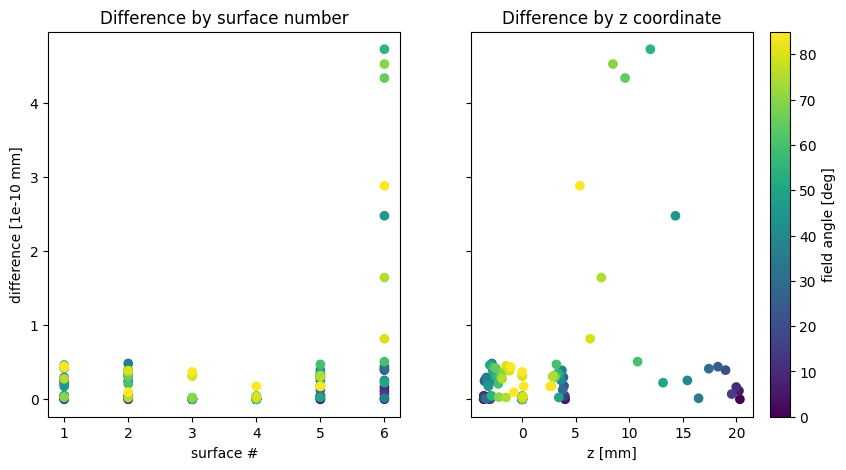

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

_field_coordinates = [f[1] for f in raytrace_comparison.field]
m = ax[0].scatter(raytrace_comparison["index"], raytrace_comparison.distance * 1e10, c=_field_coordinates)

ax[0].set_xlabel("surface #")
ax[0].set_ylabel("difference [1e-10 mm]")
ax[0].set_title("Difference by surface number")

ax[1].scatter(raytrace_comparison.z_opticstudio, raytrace_comparison.distance * 1e10, c=_field_coordinates)

ax[1].set_xlabel("z [mm]")
ax[1].set_title("Difference by z coordinate")

plt.colorbar(m, ax=ax[1], label="field angle [deg]")

## Strehl ratio analysis

Calculate the Strehl ratio for both backends and all supported PSF types, and compare the results.

In [22]:
psf_types: list[Literal["fft", "huygens"]] = ["fft", "huygens"]

strehl_ratios = {}

for backend, name in zip([OpticStudioBackend, OptilandBackend], ["OpticStudio", "Optiland"], strict=False):
    strehl_ratios[name] = {}

    for psf_type in psf_types:
        try:
            strehl_ratios[name][psf_type] = visisipy.analysis.strehl_ratio(
                model=model,
                field_coordinate=(0, 0),
                psf_type=psf_type,
                backend=backend,
            )
        except NotImplementedError:
            strehl_ratios[name][psf_type] = np.nan

pd.DataFrame(strehl_ratios).style.format(precision=3)

,OpticStudio,Optiland
fft,nan,0.677
huygens,0.671,0.667


## Zernike standard coefficients

Calculate the Zernike standard coefficients for the Navarro eye model at different field angles.
Note that the y-axes in the plots are logarithmic.

In [23]:
zernike_central_opticstudio = visisipy.analysis.zernike_standard_coefficients(
    model=model,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OpticStudioBackend,
)

zernike_central_optiland = visisipy.analysis.zernike_standard_coefficients(
    model=model,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OptilandBackend,
)

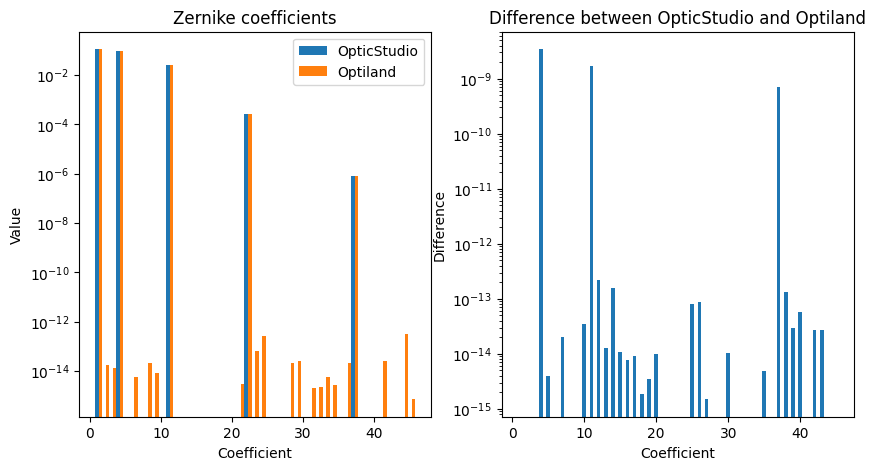

In [24]:
def compare_zernike_coefficients(
    zernike_coefficients_opticstudio: dict,
    zernike_coefficients_optiland: dict,
):
    """
    Compare Zernike coefficients from OpticStudio and Optiland.
    """
    differences = {k: (v - zernike_coefficients_optiland[k]) for k, v in zernike_coefficients_opticstudio.items()}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].bar(
        zernike_coefficients_opticstudio.keys(),
        zernike_coefficients_opticstudio.values(),
        width=0.5,
        label="OpticStudio",
    )
    ax[0].bar(
        np.fromiter(zernike_coefficients_optiland.keys(), dtype=int) + 0.5,
        zernike_coefficients_optiland.values(),
        width=0.5,
        label="Optiland",
    )

    ax[0].set_yscale("log")

    ax[0].set_title("Zernike coefficients")
    ax[0].set_xlabel("Coefficient")
    ax[0].set_ylabel("Value")
    ax[0].legend()

    ax[1].bar(differences.keys(), differences.values(), width=0.5, label="Difference")
    ax[1].axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax[1].set_title("Difference between OpticStudio and Optiland")

    ax[1].set_yscale("log")

    ax[1].set_xlabel("Coefficient")
    ax[1].set_ylabel("Difference")


compare_zernike_coefficients(zernike_central_opticstudio, zernike_central_optiland)

This is an emmetropic eye, so the aberrations are very small. They will be slightly larger at a nonzero eccentricity:

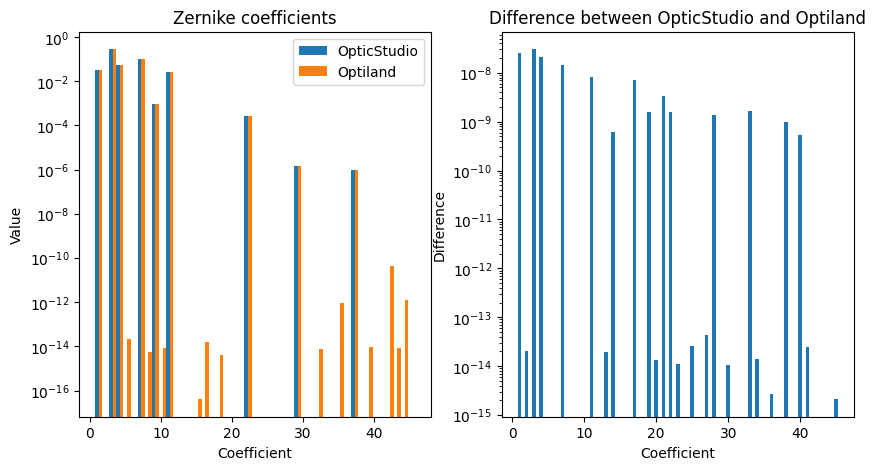

In [25]:
zernike_10deg_opticstudio = visisipy.analysis.zernike_standard_coefficients(
    model=model,
    field_coordinate=(0, 10),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OpticStudioBackend,
)

zernike_10deg_optiland = visisipy.analysis.zernike_standard_coefficients(
    model=model,
    field_coordinate=(0, 10),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OptilandBackend,
)

compare_zernike_coefficients(zernike_10deg_opticstudio, zernike_10deg_optiland)

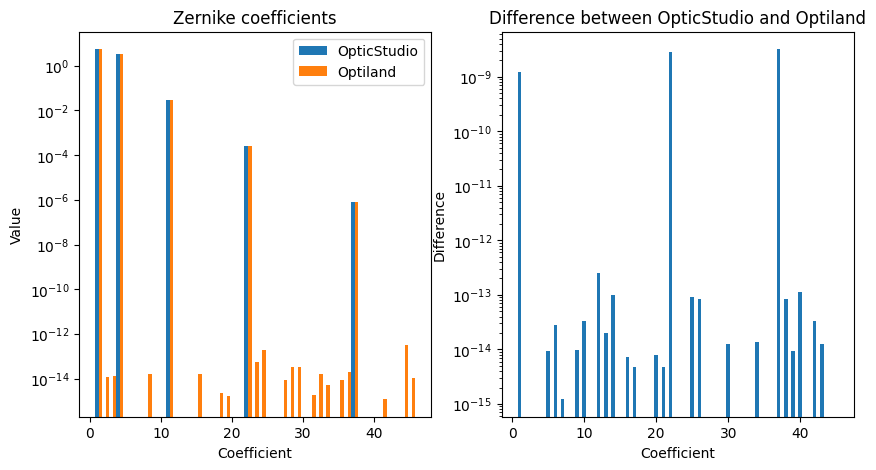

In [26]:
zernike_myopic_opticstudio = visisipy.analysis.zernike_standard_coefficients(
    model=model_myopic,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OpticStudioBackend,
)

zernike_myopic_optiland = visisipy.analysis.zernike_standard_coefficients(
    model=model_myopic,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OptilandBackend,
)

compare_zernike_coefficients(zernike_myopic_opticstudio, zernike_myopic_optiland)

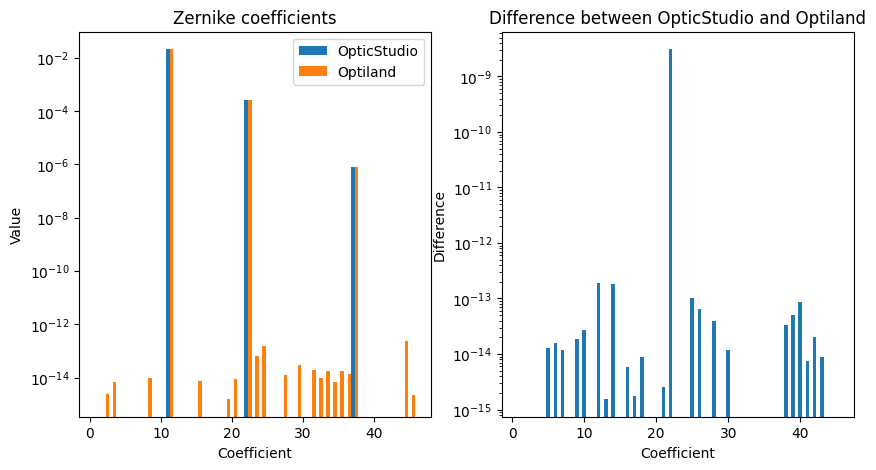

In [27]:
zernike_hyperopic_opticstudio = visisipy.analysis.zernike_standard_coefficients(
    model=model_hyperopic,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OpticStudioBackend,
)

zernike_hyperopic_optiland = visisipy.analysis.zernike_standard_coefficients(
    model=model_hyperopic,
    field_coordinate=(0, 0),
    wavelength=0.543,
    sampling=128,
    maximum_term=45,
    field_type="angle",
    backend=OptilandBackend,
)

compare_zernike_coefficients(zernike_hyperopic_opticstudio, zernike_hyperopic_optiland)

## RMS-HOA

Calculate the root-mean-square of the higher-order aberrations (RMS-HOA) for the Navarro eye model on the previously defined eye models.

In [28]:
rms_hoa_parameters = {
    "emmetropic": {
        "model": model,
        "field": (0, 0),
    },
    "myopic": {
        "model": model_myopic,
        "field": (0, 0),
    },
    "myopic_10deg": {
        "model": model_myopic,
        "field": (0, 10),
    },
    "hyperopic": {
        "model": model_hyperopic,
        "field": (0, 0),
    },
}

rms_hoa_comparison = []

for name, parameters in rms_hoa_parameters.items():
    rms_hoa_opticstudio = visisipy.analysis.rms_hoa(
        model=parameters["model"],
        field_coordinate=parameters["field"],
        wavelength=0.543,
        sampling=128,
        maximum_term=45,
        field_type="angle",
        backend=OpticStudioBackend,
    )

    rms_hoa_optiland = visisipy.analysis.rms_hoa(
        model=parameters["model"],
        field_coordinate=parameters["field"],
        wavelength=0.543,
        sampling=128,
        maximum_term=45,
        field_type="angle",
        backend=OptilandBackend,
    )

    rms_hoa_comparison.append({
        "name": name,
        "opticstudio": rms_hoa_opticstudio,
        "optiland": rms_hoa_optiland,
        "difference": rms_hoa_opticstudio - rms_hoa_optiland,
    })

pd.DataFrame(rms_hoa_comparison).set_index("name")

,opticstudio,optiland,difference
name,,,
emmetropic,0.025453,0.025453,1.659608e-09
myopic,0.029329,0.029329,-5.773913e-09
myopic_10deg,0.113635,0.113635,2.679752e-07
hyperopic,0.020970,0.020970,-4.476286e-10


## Refraction

Calculate the on-axis and off-axis refraction using both backends.

In [29]:
refraction_onaxis_opticstudio = visisipy.analysis.refraction(
    model=model,
    field_coordinate=(0, 0),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OpticStudioBackend,
)

refraction_onaxis_optiland = visisipy.analysis.refraction(
    model=model,
    field_coordinate=(0, 0),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OptilandBackend,
)

In [30]:
def compare_refractions(
    refraction_opticstudio: FourierPowerVectorRefraction,
    refraction_optiland: FourierPowerVectorRefraction,
):
    """
    Compare refractions from OpticStudio and Optiland.
    """
    df = pd.DataFrame({
        "OpticStudio": asdict(refraction_opticstudio),
        "Optiland": asdict(refraction_optiland),
    })
    df["Difference"] = df["OpticStudio"] - df["Optiland"]

    return df


compare_refractions(refraction_onaxis_opticstudio, refraction_onaxis_optiland)

,OpticStudio,Optiland,Difference
M,0.000046,4.546456e-05,1.316288e-07
J0,0.000000,-7.418248e-12,7.418248e-12
J45,0.000000,-1.580311e-12,1.580311e-12


In [31]:
refraction_offaxis_opticstudio = visisipy.analysis.refraction(
    model=model,
    field_coordinate=(0, 10),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OpticStudioBackend,
)

refraction_offaxis_optiland = visisipy.analysis.refraction(
    model=model,
    field_coordinate=(0, 10),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OptilandBackend,
)

compare_refractions(refraction_offaxis_opticstudio, refraction_offaxis_optiland)

,OpticStudio,Optiland,Difference
M,0.09206,9.205975e-02,-9.527314e-09
J0,0.11967,1.196702e-01,8.005509e-08
J45,0.00000,2.168976e-13,-2.168976e-13


In [32]:
refraction_myopic_opticstudio = visisipy.analysis.refraction(
    model=model_myopic,
    field_coordinate=(0, 0),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OpticStudioBackend,
)

refraction_myopic_optiland = visisipy.analysis.refraction(
    model=model_myopic,
    field_coordinate=(0, 0),
    sampling=128,
    wavelength=0.543,
    field_type="angle",
    backend=OptilandBackend,
)

compare_refractions(refraction_myopic_opticstudio, refraction_myopic_optiland)

,OpticStudio,Optiland,Difference
M,-5.944698,-5.944698e+00,6.936029e-08
J0,0.000000,-5.511146e-12,5.511146e-12
J45,0.000000,-1.018927e-12,1.018927e-12
